In [1]:
import numpy as np
from urllib.request import urlopen
from tqdm import tqdm
import os.path
import time

class AlignedEmbeddingLoader(object):
  """This data loader will download an aligned fasttext embedding given a two letter language code.
  More information ca be found at https://fasttext.cc/docs/en/aligned-vectors.html ."""
  def __init__(self, lang='en'):
    """Data loader"""
    self._dataurl = "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.%s.align.vec" % lang
    cachefile = "cache_%s.npz" % lang
    if os.path.exists(cachefile):
      print("Loading cached data...", end="")
      t = time.time()
      data = np.load(cachefile)
      self.idx2token_ = list(data['idx2token'])
      self.vectors_ = data['vectors']
      print("done (%isec)" % (time.time()-t), flush=True)
    else:
      with urlopen(self._dataurl) as remote_file:
        get_decoded_line = lambda file: file.readline().decode('utf-8')
        self.n_tokens, self.n_dim = [int(n) for n in get_decoded_line(remote_file).split()]
        self.idx2token_ = list()
        self.vectors_ = np.zeros((self.n_tokens, self.n_dim), dtype=np.float32)
        for n in tqdm(range(self.vectors_.shape[0]), desc="Downloading and parsing vectors"):
          textline = get_decoded_line(remote_file)
          linedata = textline.split(' ')
          self.idx2token_.append(linedata[0])
          self.vectors_[n, :] = np.asarray(linedata[1:], dtype=np.float32)
      np.savez(cachefile, vectors=self.vectors_, idx2token=self.idx2token_)
    self.token2idx_ = {token:i for i, token in enumerate(self.idx2token_)}

loaded_embedding = AlignedEmbeddingLoader('en')

#!ls -l

Loading cached data...done (33sec)


In [2]:
len(loaded_embedding.vectors_) #get the number of all word vectors

2519370

In [3]:
loaded_embedding.vectors_[0,:] # get the first word vector

array([-0.0113, -0.0021, -0.0515,  0.0208, -0.0697, -0.0385,  0.0381,
       -0.0948,  0.0109,  0.152 ,  0.028 , -0.0565,  0.0471, -0.0454,
       -0.0167, -0.0714, -0.054 , -0.0541,  0.033 ,  0.0488, -0.0328,
        0.1158, -0.0638, -0.0041, -0.0516,  0.1195,  0.0321, -0.1157,
       -0.0524,  0.0028, -0.0397,  0.128 , -0.0256,  0.0989,  0.0247,
       -0.0919, -0.056 , -0.1255,  0.0228, -0.0246,  0.0305,  0.0752,
       -0.0274, -0.0236, -0.0486, -0.0172, -0.0446, -0.0395, -0.0005,
       -0.041 , -0.0635,  0.0073, -0.042 , -0.0258, -0.0519, -0.0206,
        0.0421,  0.1102, -0.0783,  0.0918,  0.0259, -0.1046,  0.0814,
       -0.0704, -0.0776,  0.003 , -0.0373, -0.0446, -0.1412,  0.0132,
        0.0104,  0.0117,  0.0726, -0.1611, -0.0477, -0.0165,  0.0344,
        0.0113,  0.0319,  0.0912, -0.0655,  0.0703, -0.0131, -0.0112,
        0.0475, -0.016 , -0.0136, -0.0335,  0.0831, -0.029 ,  0.01  ,
       -0.0378,  0.0592, -0.0377,  0.052 ,  0.0249,  0.0037, -0.0316,
        0.044 ,  0.0

## Your analyzer
This is the analyzer. Your task is to finish this in line with the unit tests, the assignment text specifications, and the paper Bolukbasi (2016).

In [4]:
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.metrics import pairwise_distances

class EmbeddingAnalyzer(object):
  def __init__(self, embedding):
    self.vectors_ = embedding.vectors_
    self.token2idx_ = embedding.token2idx_
    self.idx2token_ = embedding.idx2token_

  def __len__(self):
    return len(self.vectors_)  #get the number of vectors


  def __getitem__(self, tokens):  # return the vectors for tokens
        if isinstance(tokens,list) and len(tokens)>1:
            vectors=self.vectors_[self.token2idx_[tokens[0]]]
            for t in tokens[1:]:
                v=self.vectors_[self.token2idx_[t]]
                vectors=np.vstack((vectors,v))
            return vectors
        else:
            return np.array([self.vectors_[self.token2idx_[tokens],:]])
    

  def __contains__(self, token): # Judge if the token is included in the analyzer
    return token in self.token2idx_

  def projection(self, direction, vectors): #get the projection
        return cosine_similarity(direction,vectors)


  def simple_analogy(self, pair, query, k=5):
    vec = lambda token: np.vstack(self.vectors_[self.token2idx_[token], :]).T  #use lambbda to get query vector
    v = vec(query) - vec(pair[0]) + vec(pair[1]) #get the match vector
    distances = pairwise_distances(self.vectors_, v, metric='euclidean').ravel() #calculate distances
    best_m=[]
    for idx in np.argsort(distances)[:k]: #get the indexes of the top 5 best match vectors
        best_m.append(self.idx2token_[idx])
    return best_m
  
  def simple_analogy2(self, pair, query, k=5): #explore different ways to implement analogy
    v = self.__getitem__(query) - self.__getitem__(pair[0]) + self.__getitem__(pair[1])
    distances = pairwise_distances(self.vectors_, v, metric='euclidean').ravel()
    best_m=[]
    for idx in np.argsort(distances)[:k]:
        best_m.append(self.idx2token_[idx])
    return best_m  

  def simple_analogy3(self, pair, query, k=5): #explore different ways to implement analogy
    vec = lambda token: np.array([self.vectors_[self.token2idx_[token], :]])
    v = vec(query) - vec(pair[0]) + vec(pair[1])
    distances = euclidean_distances(self.vectors_, v).ravel()
    best_m=[self.idx2token_[idx] for idx in np.argsort(distances)[:k]]
    return best_m

  def similarity(self, token1, token2): # get the cosine similarity value
        return cosine_similarity(self.__getitem__(token1),self.__getitem__(token2))


  def analogies(self, analogy_direction, tokens):# To be aligned with the paper, the function only return one best match pair for each token
    pair_list_final=[]
    for token1 in tokens:
        pair_list=[]
        pair_score=np.zeros(len(tokens))
        for i,token2 in enumerate(tokens):
            if token2!=token1:
                distance=euclidean_distances(self.__getitem__(token1),self.__getitem__(token2)) # get the euclidean distance
                v_minus=self.__getitem__(token1)-self.__getitem__(token2)
                if distance<=1:
                    pair_score[i]=cosine_similarity(analogy_direction,v_minus)
            pair_list.append((token1,token2))
        best_idx=np.argsort(-pair_score)[0] #get the index of the best match vector with highest cosine similarity scores/I sorted it in a reverse order
        if pair_score[best_idx]>0: #As the paper stated, the function only return pairs with positive scores
            pair_list_final.append(pair_list[best_idx])
    return pair_list_final
            
        

analyzer = EmbeddingAnalyzer(loaded_embedding)

assert 'man' in analyzer
assert 'woman' in analyzer
assert 'kdjfsfhgkdsjfdh' not in analyzer

assert len(analyzer) > 100000

assert type(analyzer['man']) is np.ndarray
assert np.isclose(np.sum(analyzer['man']-analyzer['man']), 0)

In [5]:
analyzer[["water","man"]]

array([[-4.040e-02,  7.400e-03, -9.610e-02,  1.362e-01, -3.900e-02,
        -7.760e-02, -3.880e-02, -7.040e-02, -3.270e-02,  5.410e-02,
         7.540e-02, -2.420e-02, -1.900e-03,  1.350e-02, -2.000e-04,
        -9.620e-02, -6.600e-02, -4.700e-02, -2.300e-03,  4.910e-02,
        -3.000e-02, -1.750e-02, -4.870e-02, -7.600e-03, -9.020e-02,
        -1.000e-04, -2.100e-02,  2.030e-02,  5.330e-02, -8.200e-03,
         4.200e-02,  1.590e-02, -1.041e-01,  2.470e-02,  1.000e-02,
        -6.600e-02,  1.220e-02, -3.440e-02,  3.570e-02,  1.050e-02,
         1.389e-01,  7.280e-02, -4.230e-02, -5.270e-02, -2.910e-02,
         4.700e-03,  5.980e-02, -2.140e-02, -4.800e-02,  3.570e-02,
        -9.600e-03,  5.120e-02, -1.230e-02, -1.250e-02,  2.110e-02,
         8.030e-02, -7.590e-02,  6.790e-02,  4.370e-02,  2.150e-02,
        -6.300e-03, -7.580e-02,  2.600e-02,  3.410e-02, -2.490e-02,
        -7.580e-02, -1.056e-01, -4.500e-03,  4.400e-02, -6.240e-02,
        -1.193e-01, -1.090e-02,  3.930e-02, -2.5

In [6]:
analyzer.similarity('cat', 'dog')

array([[0.63804495]], dtype=float32)

In [7]:
analyzer.similarity('cat', 'cow') 

array([[0.39173397]], dtype=float32)

## Word similarity

We should be able to meassure similarity as cosine similarity.

$cos(\overrightarrow{cat}, \overrightarrow{dog}) \geq cos(\overrightarrow{cat}, \overrightarrow{cow})$

In [8]:
assert analyzer.similarity('cat', 'dog') >= analyzer.similarity('cat', 'cow')

## Word analogies

One of the core tasks for showing any semantic properties in an embedding is finding word analogies. We can this of this as word a is to word b, as word c is to word d. Our task is to find word d, knowing a, b, and c.

$\overrightarrow{a} - \overrightarrow{b} \approx \overrightarrow{c} - \overrightarrow{d}$

For gender, this becomes:

$\overrightarrow{man} - \overrightarrow{woman} \approx \overrightarrow{king} - \overrightarrow{x}$

By rearranging we get:

$\overrightarrow{king} - \overrightarrow{man} + \overrightarrow{woman} \approx \overrightarrow{x}$

In [9]:
best_matches = analyzer.simple_analogy(('man', 'woman'), 'king', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'queen' in analyzer.simple_analogy(('man', 'woman'), 'king', k=5)

Matches (in order of similarity):
1 king
2 queen
3 princess
4 regnant
5 princesses


We can do this for capitols too.

$\overrightarrow{France} - \overrightarrow{Japan} \approx \overrightarrow{Paris} - \overrightarrow{x}$

In [10]:
best_matches = analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'tokyo' in analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)

Matches (in order of similarity):
1 tokyo
2 japan
3 osaka
4 kyoto
5 tokyo 


Please try doing this for at least one other famous category (e.g. comparing adjectives).

We can do this for adjectives too.

$\overrightarrow{Beautiful} - \overrightarrow{Handsome} \approx \overrightarrow{Girl} - \overrightarrow{Boy}$

In [11]:
best_matches=analyzer.simple_analogy(("beautiful","handsome"),"girl",k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
    print(i+1,token)
    
assert "boy" in analyzer.simple_analogy(("beautiful","handsome"),"girl",k=5)

Matches (in order of similarity):
1 girl
2 boy
3 handsome
4 teenaged
5 teenager


In [12]:
best_matches2=analyzer.simple_analogy2(("beautiful","handsome"),"girl",k=5) #test my second simple analogy function
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches2):
    print(i+1,token)
    
assert "boy" in analyzer.simple_analogy(("beautiful","handsome"),"girl",k=5)

Matches (in order of similarity):
1 girl
2 boy
3 handsome
4 teenaged
5 teenager


In [13]:
best_matches3=analyzer.simple_analogy3(("beautiful","handsome"),"girl",k=5) # test my third simple analogy function
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches3):
    print(i+1,token)
    
assert "boy" in analyzer.simple_analogy(("beautiful","handsome"),"girl",k=5)

Matches (in order of similarity):
1 girl
2 boy
3 handsome
4 teenaged
5 teenager


## Finding the genderedness of professions

Bulokbasi (2016) has a repo for the paper. We can download their data for professions. This allows us to find the genderedness for our embedding and plot against their survey data.

In [14]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json') as remote_file:
  professions = {title: {'definitional': defi, 'stereotypical': ster} for title, defi, ster in json.load(remote_file)}
print("Loaded %i professions" % len(professions))

Loaded 320 professions


We want to find the projection of vectors for different profession on a gender direction. This can be done by finding the cosine similarity as:

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{butcher})$

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{ballerina})$

The projection should be non-negative as $|cos(\cdot,\cdot)|$. However, by letting the projection method of the anlayzer give us the ccosine similarity, we can see the direction of the projection by looking at its sign.

In [15]:
assert type(analyzer[['man', 'woman', 'butcher']]) is np.ndarray
assert analyzer[['man', 'woman', 'butcher']].shape[0] == 3

assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['butcher']) > 0
assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['ballerina']) < 0

We create a woman-man direction.

In [16]:
direction = analyzer['man']-analyzer['woman']
titles = [title for title in professions.keys() if title in analyzer]
projection = analyzer.projection(direction, analyzer[titles])

The estimation of the gender direction can be improved by using several pairs. Again, we use the data from Bulokbasi (2016).

In [17]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/definitional_pairs.json') as remote_file:
  definitional_pairs = [(m, f) for m, f in json.load(remote_file)]
definitional_pairs

[('woman', 'man'),
 ('girl', 'boy'),
 ('she', 'he'),
 ('mother', 'father'),
 ('daughter', 'son'),
 ('gal', 'guy'),
 ('female', 'male'),
 ('her', 'his'),
 ('herself', 'himself'),
 ('Mary', 'John')]

In [18]:
direction2 = np.zeros(analyzer['man'].shape) # get the direction2 for testing the complex analogy function
for female, male in definitional_pairs:
  direction2 += analyzer[male.lower()]
  direction2 -= analyzer[female.lower()]

projection2 = analyzer.projection(direction2, analyzer[titles])

We can plot the relation between genderedness in the data and human annotation.

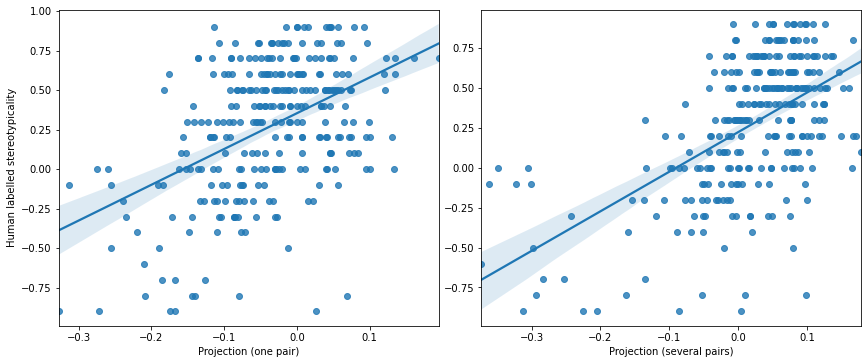

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
stereotypicality = [professions[title]['stereotypical'] for title in titles]
sns.regplot(x=projection, y=stereotypicality, ax=ax[0])
a = sns.regplot(x=projection2, y=stereotypicality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled stereotypicality")
fig.tight_layout(pad=.5)
fig.show()

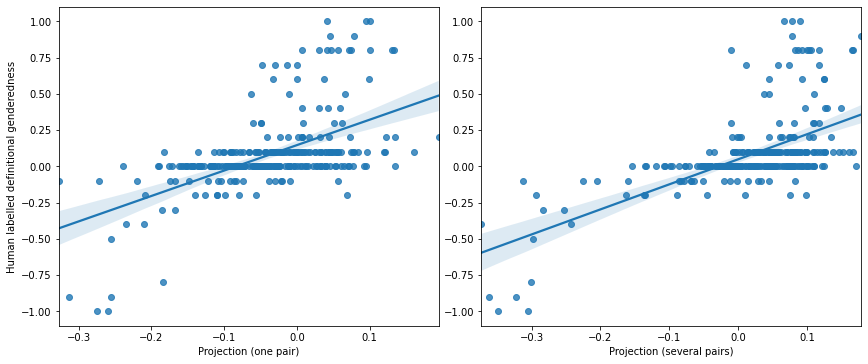

In [20]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
definitionality = [professions[title]['definitional'] for title in titles]
sns.regplot(x=projection, y=definitionality, ax=ax[0])
a = sns.regplot(x=projection2, y=definitionality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled definitional genderedness")
fig.tight_layout(pad=.5)
fig.show()

Based on the plots, we can see that the diagnol line is the gender direction and definitely conclude that data projections vary largely from human labelled annotations,which shows that a gender bias in word embeddings or human labelled data exists

## More analogies

The paper defines a more advances procedure for analogies as:

$S_{(a,b)}(x, y) = \left\{\begin{matrix}
cos(\overrightarrow{a}-\overrightarrow{b}, \overrightarrow{x}-\overrightarrow{y}) & \parallel \overrightarrow{x}-\overrightarrow{y} \parallel \leq 1\\ 
0 &  \text{otherwise}
\end{matrix}\right.$

This should return a list of tuples with word pairs.

In [21]:
assert len(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == 1
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == list
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])[0]) == tuple

analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])

[('actor', 'actress')]

In [22]:
analyzer.analogies(analogy_direction=direction2, tokens=titles)

[('accountant', 'businesswoman'),
 ('actor', 'actress'),
 ('actress', 'waitress'),
 ('administrator', 'bureaucrat'),
 ('adventurer', 'protagonist'),
 ('advocate', 'campaigner'),
 ('aide', 'counselor'),
 ('alderman', 'solicitor'),
 ('alter_ego', 'fashion_designer'),
 ('ambassador', 'secretary'),
 ('analyst', 'columnist'),
 ('anthropologist', 'pediatrician'),
 ('archaeologist', 'anthropologist'),
 ('archbishop', 'parishioner'),
 ('architect', 'painter'),
 ('artist', 'singer'),
 ('artiste', 'performer'),
 ('assassin', 'bodyguard'),
 ('astronomer', 'archaeologist'),
 ('athlete', 'swimmer'),
 ('attorney', 'paralegal'),
 ('author', 'novelist'),
 ('ballerina', 'actress'),
 ('banker', 'businesswoman'),
 ('barber', 'hairdresser'),
 ('barrister', 'campaigner'),
 ('bartender', 'waitress'),
 ('biologist', 'pediatrician'),
 ('bishop', 'parishioner'),
 ('bookkeeper', 'waitress'),
 ('boss', 'bartender'),
 ('boxer', 'wrestler'),
 ('broadcaster', 'columnist'),
 ('broker', 'realtor'),
 ('businessman', '

## Education part
To my mind, defining the complex analogies is the most difficult part, because we have to find the best match pair for each token, which is a little bit time-consuming. Furthermore, I misunderstood the output of the complex analogies function at first and thought it should output one pair with the highest cosine_similarity score, so I read the article again, then realized that this function is to find the best match pair for each token, not the best match pair among all possible pairs. After designing my Embedding analyzer, I prefer importing the Word2Vec from gensim models or other word vector modules, which are more convenient. Generally speaking, each part inside my analyzer class is necessary to make sure our tokens are contained by the word embedding vectors and return the right vector for the token. At last, I would like to mention that the trickiest part of my complex analogy is to ensure that vectors used to calculate the euclidean distance must be 2D arrays.